In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True) # Set GPU memory usage on demand
    tf.config.set_visible_devices([gpus[0]], "GPU")

print(gpus)
import tensorflow as tf
print(tf.__version__)

print("current device：", tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.6.2
当前设备： /device:GPU:0


In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

import os,PIL
import numpy as np
np.random.seed(1)
tf.random.set_seed(1)
import pathlib

In [3]:

data_dir = "D:\\cvLearning\\clustering\\data3_a"


data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：", image_count)

图片总数为： 6180


In [5]:
batch_size = 32
img_height = 224
img_width = 224

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 12,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 6180 files belonging to 8 classes.
Using 4944 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 12,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 6180 files belonging to 8 classes.
Using 1236 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['B_a', 'C_a', 'D_a', 'Denvour_a', 'Grant_a', 'MOH_a', 'Monica_a', 'yongsong_a']


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [10]:
# model = tf.keras.applications.MobileNetV2()
# model.summary()


# Load the model (excluding the top layer)
base_model = tf.keras.applications.EfficientNetB7(include_top=False)

# Remove the last layer of the original model
x = base_model.output

# Add a new fully connected layer as the output layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(8, activation='softmax')(x)  # Assuming there are 8 categories

# The new complete model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Display the summary of the new model
model.summary()



# not transfer learning
# import tensorflow as tf

# input_shape = (img_height, img_width, 3) 

# model = tf.keras.applications.EfficientNetB7(include_top=False, weights=None, input_shape=input_shape)

# x = model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# predictions = tf.keras.layers.Dense(8, activation='softmax')(x)

# model = tf.keras.Model(inputs=model.input, outputs=predictions)

# model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
______________________________________________________________________________________________

In [11]:
# Set dynamic learning rate

initial_learning_rate = 1e-3

# Exponential Decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 20,  # Not epochs
    decay_rate = 0.99,  # After each decay, the learning rate becomes decay_rate * lr
    staircase = True
)

optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)


In [12]:
model.compile(optimizer = optimizer,
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [13]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/50
155/155 [==============================] - 75s 376ms/step - loss: 0.9479 - accuracy: 0.6857 - val_loss: 0.6330 - val_accuracy: 0.8050
Epoch 2/50
155/155 [==============================] - 53s 343ms/step - loss: 0.5460 - accuracy: 0.8297 - val_loss: 0.4870 - val_accuracy: 0.8576
Epoch 3/50
155/155 [==============================] - 53s 342ms/step - loss: 0.4454 - accuracy: 0.8610 - val_loss: 0.4227 - val_accuracy: 0.8641
Epoch 4/50
155/155 [==============================] - 53s 342ms/step - loss: 0.3977 - accuracy: 0.8712 - val_loss: 0.3879 - val_accuracy: 0.8778
Epoch 5/50
155/155 [==============================] - 53s 342ms/step - loss: 0.3651 - accuracy: 0.8807 - val_loss: 0.3652 - val_accuracy: 0.8843
Epoch 6/50
155/155 [==============================] - 53s 343ms/step - loss: 0.3464 - accuracy: 0.8894 - val_loss: 0.3568 - val_accuracy: 0.8811
Epoch 7/50
155/155 [==============================] - 53s 342ms/step - loss: 0.3210 - accuracy: 0.8999 - val_loss: 0.3335 - val_ac

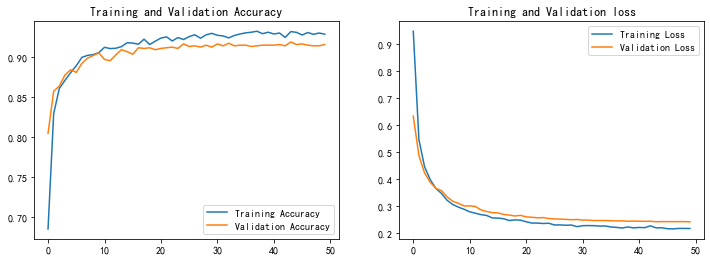

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)

plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Define a function to plot the confusion matrix
def plot_cm(labels, predictions):
    
    # Generate the confusion matrix
    conf_numpy = confusion_matrix(labels, predictions)
    # Convert the matrix to a DataFrame
    conf_df = pd.DataFrame(conf_numpy, index = class_names, columns = class_names)
    
    plt.figure(figsize = (8, 7))
    sns.heatmap(conf_df, annot = True, annot_kws={"fontsize":12}, cmap = "BuPu")
    
    plt.title('Confusion Matrix', fontsize = 15)
    plt.ylabel('True Labels', fontsize = 14)
    plt.xlabel('Predicted Labels', fontsize = 14)


In [16]:
val_pre = []
val_label = []

for images, labels in val_ds:  # You can take a subset of validation data (.take(1)) to generate the confusion matrix
# for images, labels in val_ds.take(1):  # You can take a subset of validation data (.take(1)) to generate the confusion matrix
    for image, label in zip(images, labels):
        # Need to add one dimension to the image
        img_array = tf.expand_dims(image, 0)
        # Use the model to predict the person in the image
        prediction = model.predict(img_array)
        
        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])


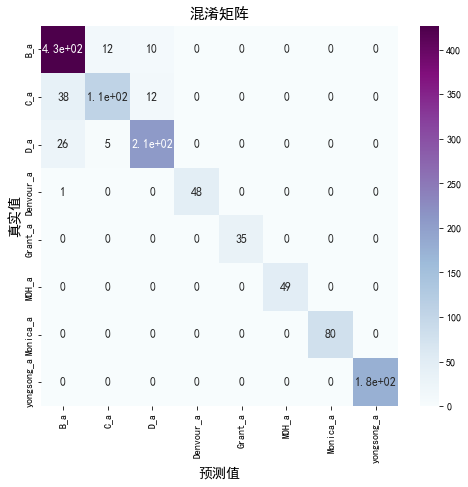

In [17]:
plot_cm(val_label, val_pre)

In [18]:
model.save('model/style.h5')

D:\tf\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
new_model = tf.keras.models.load_model('model/style.h5')

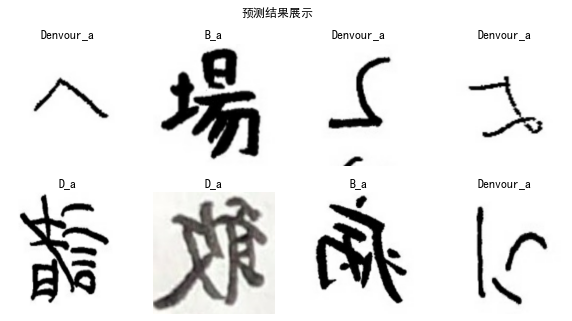

In [20]:
plt.figure(figsize = (10, 5))
plt.suptitle("Forecast Result Display")

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2,4,i+1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        img_array = tf.expand_dims(images[i], 0)
        
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])
        
        plt.axis("off")